# 크롤러 튜토리얼

이거 하나로 나도 크롤링 전문가!

Copyright 2020. `Ho Kim`. All rights reversed, For education only.

## POST 신호 보내보기

HTTP 에서 웹 페이지에 접근하는 방법이 여러가지가 있습니다.
* GET
* POST
* ...

그중, 가장 자주 쓰이는 친구들은 GET과 POST의 2가지입니다.

GET은 웹 링크(URL)에 변수들을 실어나를 수 있습니다. 길이 제한이 있고, 비밀번호 같은건 보안에 취약해 전송할 수 없습니다.

POST는 웹 패킷에 변수들을 실어나를 수 있습니다. 암호화를 할 수 있어 GET보다 안전합니다.

In [1]:
# 시각화 라이브러리가 Jupyter Notebook에 그림을 그릴 수 있도록 합니다.
%matplotlib inline

# --------------------------------------
#  아래 라이브러리는 수동으로 설치해야 합니다.
# --------------------------------------

from google_images_download import google_images_download as gid  # 이미지 크롤링 라이브러리
from PIL import Image  # 이미지 라이브러리

# 웹 크롤러 라이브러리 로드하기
import requests  # cURL 라이브러리

# 데이터과학 라이브러리 로드하기
import pandas as pd  # 데이터 가공 라이브러리
import matplotlib.pyplot as plt  # 시각화 라이브러리
import xlrd as _  # 엑셀 파일 파싱 라이브러리

In [2]:
# GET 보내기
url = 'https://datalab.naver.com/keyword/trendSearch.naver'

r = requests.get(url)
r.text.split('<title>')[1].split('</title>')[0]

'[접근 오류] 서비스에 접속할 수 없습니다.'

## 헤더 보안이 적용된 웹 페이지 뚫기

정상적인 인터넷 브라우저로 위의 사이트를 들어가면 분명히 결과가 잘 나옵니다.
차이가 무엇일까?

인터넷 브라우저가 웹 사이트를 요구할 땐, `User-Agent`라는 특수한 헤더를 포함시킵니다.
이 헤더에는 인터넷 브라우저, OS, 웹 엔진에 대한 정보가 들어있습니다.

그렇다면, 이 헤더 정보를 같이 보낸다면 정보가 잘 나올 겁니다.

In [3]:
# GET 보내기
url = 'https://datalab.naver.com/keyword/trendSearch.naver'
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

r = requests.get(url, headers=headers)
r.text.split('<title>')[1].split('</title>')[0]

'검색어트렌드 : 네이버 데이터랩'

## Naver 공략하기

이전에 우리가 공략해야 할 URL `https://datalab.naver.com/qcHash.naver`를 얻었습니다.

그리고, 이 사이트가 POST를 사용한다는 것을 알고 있습니다.

이제, 이 사이트를 공략해야 할 시간입니다.

In [4]:
url = 'https://datalab.naver.com/qcHash.naver'

r = requests.post(
    url,
    headers={
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36',
        # 어느 사이트에서 이 경로를 요청하는가?
        'referer': r'https://datalab.naver.com/keyword/trendSearch.naver',
    },
    params={
        'queryGroups': '트와이스__SZLIG__트와이스__OUML__블랙핑크__SZLIG__블랙핑크',
        'startDate': 20191007,
        'endDate': 20201007,
        'timeUnit': 'date',
        'gender': '',
        'age': '',
        'device': '',
    },
)
r.text

'{"code":"","message":"","hashKey":"N_3a02ca8a01df06f4428503f167c3b63d","success":true}'

In [5]:
# hashKey 가져오기
hash_key = r.json()['hashKey']
hash_key

'N_3a02ca8a01df06f4428503f167c3b63d'

## 결과 파일 다운로드하기

이전에 결과 파일을 다운로드하는 URL도 구했습니다.

이제, 이 URL에 접속해서 결과 엑셀 파일을 다운로드할 시간입니다.

In [6]:
url = 'https://datalab.naver.com/qcExcel.naver'

# 결과 파일 다운로드하기
r = requests.get(
    url,
    headers={
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36',
    },
    params={
        'hashKey': hash_key,
    },
)

# 엑셀 파일 파싱하기
df = pd.read_excel(r.content)
df

,url,http://datalab.naver.com/keyword/trendResult.naver?hashKey=N_3a02ca8a01df06f4428503f167c3b63d,Unnamed: 2,Unnamed: 3
0,주제,통검,NaN,NaN
1,범위,합계,NaN,NaN
2,기간,일간 : 2019-10-07 ~ 2020-10-07,NaN,NaN
3,성별,"전체(여성,남성)",NaN,NaN
4,연령대,전체,NaN,NaN
...,...,...,...,...
368,2020-10-03,5.89506,2020-10-03,38.12865
369,2020-10-04,5.39907,2020-10-04,26.34309
370,2020-10-05,5.39984,2020-10-05,25.48569
371,2020-10-06,5.4189,2020-10-06,27.13607


## 데이터 가공하기

와! 트와이스 vs 블랙핑크 트렌드 데이터를 가져왔습니다.

그런데, 뭔가 이상합니다.
데이터에 필요없는 행이 앞에 6개나 있습니다.

이 필요없는 데이터 행을 제거하는 방법이 있습니다.
바로, 특정 행부터 데이터가 있다고 파싱 함수에 알려주는 겁니다.

In [7]:
# 엑셀 파일 파싱하기
df = pd.read_excel(r.content, header=6)
df

,날짜,트와이스,날짜.1,블랙핑크
0,2019-10-07,9.13177,2019-10-07,2.72660
1,2019-10-08,8.21642,2019-10-08,2.87910
2,2019-10-09,9.32543,2019-10-09,42.53919
3,2019-10-10,8.67657,2019-10-10,22.41292
4,2019-10-11,8.33460,2019-10-11,5.68043
...,...,...,...,...
362,2020-10-03,5.89506,2020-10-03,38.12865
363,2020-10-04,5.39907,2020-10-04,26.34309
364,2020-10-05,5.39984,2020-10-05,25.48569
365,2020-10-06,5.41890,2020-10-06,27.13607


성공입니다.
그런데 날짜가 중복되는 것이 조금 거슬립니다.

중복되는 날짜를 제거하는 방법이 있습니다.
파이썬의 `del` 함수를 써서 아래처럼 필요없는 열을 제거할 수도 있습니다.

```python
del df['날짜.1']
```

그리고, `drop` 함수를 사용해서 아래처럼 여러 열을 제거할 수 있습니다.

In [8]:
# 중복되는 열 제거하기
df = df.drop(df.columns[2::2], 1)
df

,날짜,트와이스,블랙핑크
0,2019-10-07,9.13177,2.72660
1,2019-10-08,8.21642,2.87910
2,2019-10-09,9.32543,42.53919
3,2019-10-10,8.67657,22.41292
4,2019-10-11,8.33460,5.68043
...,...,...,...
362,2020-10-03,5.89506,38.12865
363,2020-10-04,5.39907,26.34309
364,2020-10-05,5.39984,25.48569
365,2020-10-06,5.41890,27.13607


## API 만들기

짜잔! 이제 모든 구현이 끝났습니다.
이제 이 기능을 쉽게 사용할 수 있는 API 함수를 만들 시간입니다.

In [9]:
# API로 만들기
def get_trend(*, query, start_date, end_date, gender='', age='', device=''):
    url = 'https://datalab.naver.com/qcHash.naver'

    # hashKey 요청하기
    query = '__OUML__'.join('__SZLIG__'.join([k, k] + v) for k, v in query.items())
    r = requests.post(
        url,
        headers={
            'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36',
            # 어느 사이트에서 이 경로를 요청하는가?
            'referer': r'https://datalab.naver.com/keyword/trendSearch.naver',
        },
        params={
            'queryGroups': query,
            'startDate': start_date,
            'endDate': end_date,
            'timeUnit': 'date',
            'gender': gender,
            'age': age,
            'device': device,
        },
    )

    # hashKey 가져오기
    hash_key = r.json()['hashKey']

    url = 'https://datalab.naver.com/qcExcel.naver'

    # 결과 파일 다운로드하기
    r = requests.get(
        url,
        headers={
            'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36',
        },
        params={
            'hashKey': hash_key,
        },
    )

    # 엑셀 파일 파싱하기
    df = pd.read_excel(r.content, header=6, )

    # 데이터 가공하기
    df = df.drop(df.columns[2::2], 1)  # 날짜 열이 중복되니 없앱니다.
    return df

In [10]:
# API 호출하기
get_trend(
    query={
        # "주제어": ["검색어", ...],
        '트와이스': [],
        '블랙핑크': [],
    },
    start_date=20191007,
    end_date=20201007,
)

,날짜,트와이스,블랙핑크
0,2019-10-07,9.13177,2.72660
1,2019-10-08,8.21642,2.87910
2,2019-10-09,9.32543,42.53919
3,2019-10-10,8.67657,22.41292
4,2019-10-11,8.33460,5.68043
...,...,...,...
362,2020-10-03,5.89506,38.12865
363,2020-10-04,5.39907,26.34309
364,2020-10-05,5.39984,25.48569
365,2020-10-06,5.41890,27.13607


## 시각화

데이터가 화면에 좌르륵 보이는 게 참 좋긴 한데,
역시 데이터는 차트로 봐야 더 멋있는 법입니다.

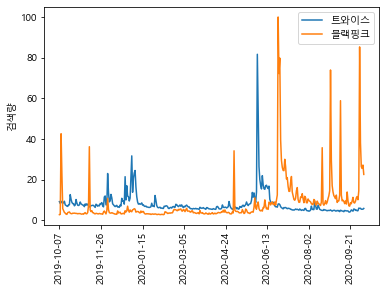

In [11]:
# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 시각화하기
df.plot(x='날짜', xlabel='', ylabel='검색량', rot=90);

## 대세 분석하기

트와이스 vs 블랙핑크 싸움 실화냐? 가슴이 웅장해진다..

이제 마지막 단계, 어느 쪽이 대세인지 판단할 차롑니다.

사실 이것만 가지고는 어디가 대세인지 단정지을 수가 없습니다.
그래서 그냥, 검색량이 더 많은 날을 세서, 더 많은 쪽이 대세라고 하겠습니다.

In [12]:
# 대세 판독하기
keyword_1 = df[df.columns[1]]
keyword_2 = df[df.columns[2]]
is_keyword_1_more_famous = (keyword_1 > keyword_2).mean() >= 0.5
is_keyword_1_more_famous  # True면, keyword_1 이 더 인기가 많은 것이다.

True

## API 만들기 2

이제 마지막으로, 키워드만 넣으면 어느 쪽이 대세인지 판단하는 함수를 만듭시다.

In [13]:
def which_is_famous(*names, start_date=20191007, end_date=20201007):
    # 트렌드 정보 불러오기
    df = get_trend(
        query={n: [] for n in names},
        start_date=start_date,
        end_date=end_date,
    )

    # 대세 분석하기
    keyword_1 = df[df.columns[1]]
    keyword_2 = df[df.columns[2]]
    is_keyword_1_more_famous = (keyword_1 > keyword_2).mean() >= 0.5

    name = names[0] if is_keyword_1_more_famous else names[1]

    # 대세 이미지 불러오기
    response = gid.googleimagesdownload()
    paths = response.download({
        'keywords': name,
        'limit': 2,
        'no_download': True,
        'silent_mode': True,
    })
    url = paths[0][name][1]

    r = requests.get(url, stream=True)
    im = Image.open(r.raw)

    # 대세 발표하기
    return im

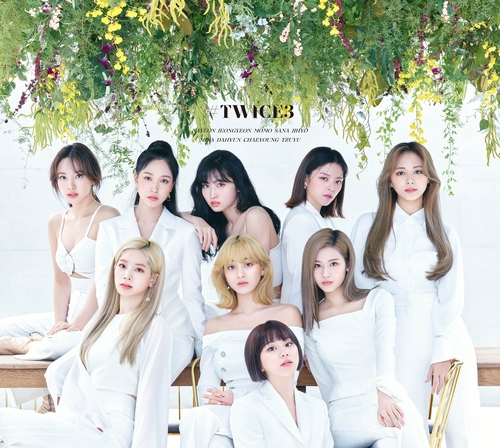

In [14]:
# 트와이스 vs 블랙핑크, 그 승자는?
which_is_famous('트와이스', '블랙핑크')

ㄹㅇㅋㅋ